# Interaction and coordination modelling

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import src.visualise.visualise_utils as vutils
from src import utils
from src.features.features_utils import PhaseCorrection, GrangerCausality, CrossCorrelation
from src.visualise.coordination_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load in data
We need to unserialise our list of onsets first

In [2]:
onsets: list = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Create models for each track

In [3]:
models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Iterate over every instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Subset to get my onsets and partner onsets as separate dataframes
        mine = summary_dict[instr]
        theirs = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
        # Create models - phase correction, granger causality, cross correlation
        model = PhaseCorrection(my_beats=mine, their_beats=theirs, order=1)
        gc = GrangerCausality(my_beats=mine, their_beats=theirs, order=1)
        cc = CrossCorrelation(my_beats=mine, their_beats=theirs, order=1)
        # Append track metadata and summary data from each model type
        models.append(track.item | model.summary_dict | dict(instrument=instr) | gc.summary_dict | cc.summary_dict)
df = pd.DataFrame(models)

In [4]:
# Clean to remove models with fewer than 30 observations
clean = df[df['nobs'] >= 30]

In [29]:
# Get the total number of rows (= total number of models)
clean.shape

(606, 58)

## Bootstrap mean R<sup>2</sup>

In [30]:
vals = clean['rsquared_adj']
boots = [vals.sample(frac=1, replace=True, random_state=i).mean() for i in range(vutils.N_BOOT)]
print(np.percentile(boots, 2.5), vals.mean(), np.percentile(boots, 97.5))

0.6130363240647562 0.6236735602500998 0.6340607415678008


## Create triangle plot of mean coupling coefficients

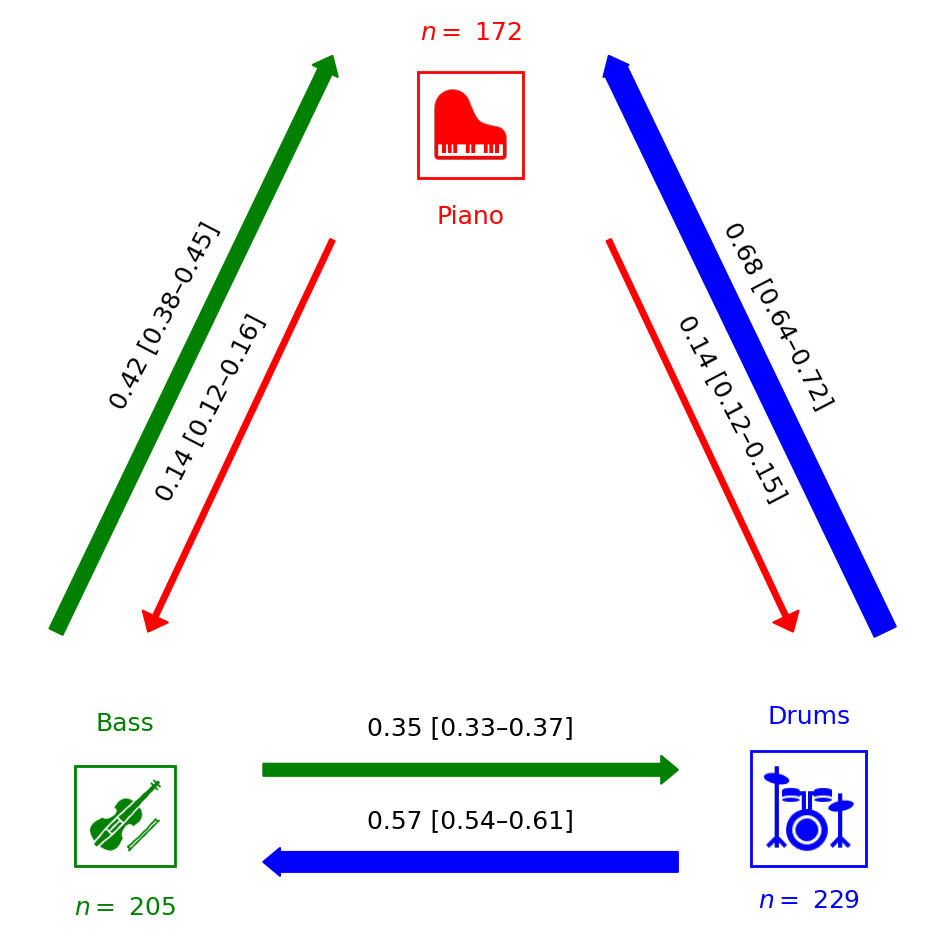

In [23]:
class TriangleWrapper(vutils.BasePlot):
    def __init__(self, model_df, **kwargs):
        self.corpus_title = kwargs.get('corpus_title', 'corpus_chronology')
        super().__init__(figure_title=fr'coordination_plots\triangleplot_alltrios_{self.corpus_title}', **kwargs)
        self.df = model_df.copy(deep=True)
        self.df.loc['pianist', :] = ''
        self.df['performer'] = ''
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))

    def _create_plot(self):
        TriangleAxis(self.df, self.ax).create_plot()

    def _format_fig(self):
        self.fig.subplots_adjust(top=0.99, bottom=0.01, left=0.01, right=0.99)

TriangleWrapper(clean).create_plot()
plt.show()

## Create bar plot of coupling coefficients

C:\Users\huwch\AppData\Local\Temp\ipykernel_14648\3406942303.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.stripplot(data=self.df.groupby('variable').mean().reset_index(drop=False), x='variable', y='value', s=10, color=vutils.BLACK, marker='s')


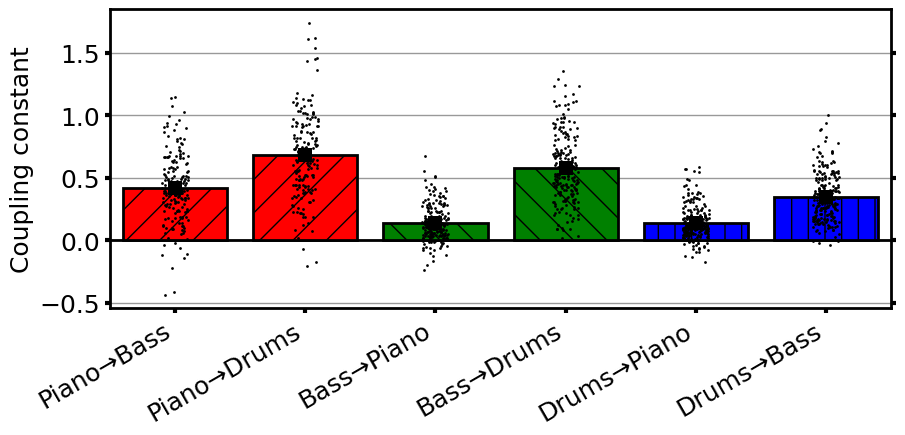

In [60]:
import seaborn as sns
class BarPlotCouplingCoefficients(vutils.BasePlot):
    BAR_KWS = dict(
        dodge=True, errorbar=None, width=0.8, estimator=np.mean,
        zorder=3, hue_order=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys(),
        ec=vutils.BLACK, ls=vutils.LINESTYLE, lw=vutils.LINEWIDTH, alpha=1,
    )
    def __init__(self, model_df, **kwargs):
        self.corpus_title = kwargs.get('corpus_title', 'corpus_chronology')
        super().__init__(figure_title=fr'coordination_plots\barplot_coefficients_{self.corpus_title}', **kwargs)
        self.df = (
            model_df.melt(id_vars=['mbz_id', 'instrument'], value_vars=['coupling_piano', 'coupling_bass', 'coupling_drums'])
            .dropna()
            .reset_index(drop=False)
            .set_index('instrument')
            .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
            .reset_index(drop=False)
        )
        self.df['variable'] = self.df['instrument'].str.title() + '→' + self.df['variable'].str.replace('coupling_', '').str.title()
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 4))

    def _create_plot(self):
        sns.barplot(data=self.df, x='variable', y='value', **self.BAR_KWS)
        sns.stripplot(data=self.df, x='variable', y='value', s=2, color=vutils.BLACK, zorder=5)
        sns.stripplot(data=self.df.groupby('variable').mean().reset_index(drop=False), x='variable', y='value', s=10, color=vutils.BLACK, marker='s')

    def _format_ax(self):
        for patch, col, hatch in zip(self.ax.patches, [val for val in vutils.RGB for _ in (0, 1)], [val for val in vutils.HATCHES for _ in (0, 1)]):
            patch.set_facecolor(col)
            patch.set_hatch(hatch)
        self.ax.axhline(0, 0, 1, lw=vutils.LINEWIDTH, ls=vutils.LINESTYLE, color=vutils.BLACK)
        self.ax.set_xticklabels(self.ax.get_xticklabels(), rotation=30, ha='right')
        self.ax.yaxis.grid(True, zorder=0, **vutils.GRID_KWS)
        plt.setp(self.ax.spines.values(), linewidth=vutils.LINEWIDTH)
        self.ax.tick_params(axis='both', bottom=True, right=True, width=vutils.TICKWIDTH)
        self.ax.set(xlabel='', ylabel='Coupling constant')

    def _format_fig(self):
        self.fig.tight_layout()

BarPlotCouplingCoefficients(clean).create_plot()
plt.show()

## Control analyses

### Compare coupling across 1st/2nd half of a track

In [3]:
partial_models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Get the duration of the track
    duration = np.ceil(summary_dict['beats'].max())
    # Get the timestamps for the start and end of the first and second half
    first_half_range = 0, np.ceil(duration / 2)
    second_half_range = first_half_range[1], duration
    # Get the data for the first and second half using hte timestamps
    first_half = summary_dict[(first_half_range[0] <= summary_dict['beats']) & (summary_dict['beats'] <= first_half_range[1])]
    second_half = summary_dict[(second_half_range[0] <= summary_dict['beats']) & (summary_dict['beats'] <= second_half_range[1])]
    # Iterate over each half separately
    for data, half in zip([first_half, second_half], [1, 2]):
        # Create the model for each instrument from the data for each half
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            mine = data[instr]
            theirs = data[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
            partial_model = PhaseCorrection(my_beats=mine, their_beats=theirs)
            # Append the model results, plus some additional metadata
            partial_models.append(track.item | partial_model.summary_dict | dict(instrument=instr, half=half))
partial_df = pd.DataFrame(partial_models)

In [4]:
# Get the minimum number of observations for a half, per instrument and track
small = (partial_df.groupby(['mbz_id', 'instrument'])['nobs'].min() >= 30).reset_index(drop=False)
checker = {}
# Iterate through the rows of the dataframe of acceptable/non-acceptable tracks
for idx, row in small[small['nobs']][['mbz_id', 'instrument']].iterrows():
    # If this row and instrument is acceptable, add the mbz_id as a dictionary key and the instrument to a list (value)
    if row['mbz_id'] not in checker.keys():
        checker[row['mbz_id']] = [row['instrument']]
    else:
        checker[row['mbz_id']].append(row['instrument'])

In [5]:
# Get the acceptable rows in the full dataframe based on our dictionary of lists
is_ok = [row for _, row in partial_df.iterrows() if row['mbz_id'] in checker.keys() and row['instrument'] in checker[row['mbz_id']]]

In [31]:
# Combine the acceptable rows into one dataframe and pivot to get coupling responses as their own column
melt = (
    pd.DataFrame(is_ok)
    .melt(id_vars=['mbz_id', 'half'], value_vars=['coupling_piano', 'coupling_drums', 'coupling_bass', 'half'])
    .dropna()
    .pivot_table(values='value', index=['mbz_id', 'variable'], columns='half')
    .reset_index(drop=False)
    .rename(columns={1: 'half_1', 2: 'half_2'})
)
melt['variable'] = melt['variable'].str.replace('coupling_', '')

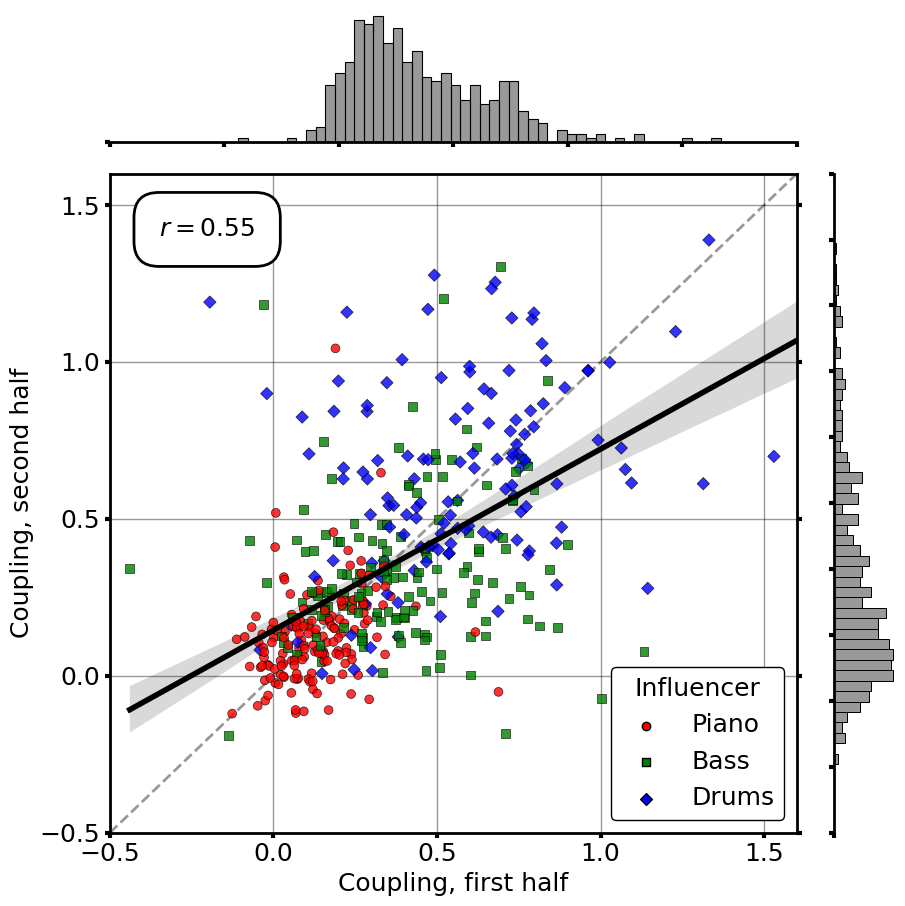

In [69]:
RegPlotCouplingHalves(melt).create_plot()
plt.show()

### Compare coupling, granger causality, and cross-correlation

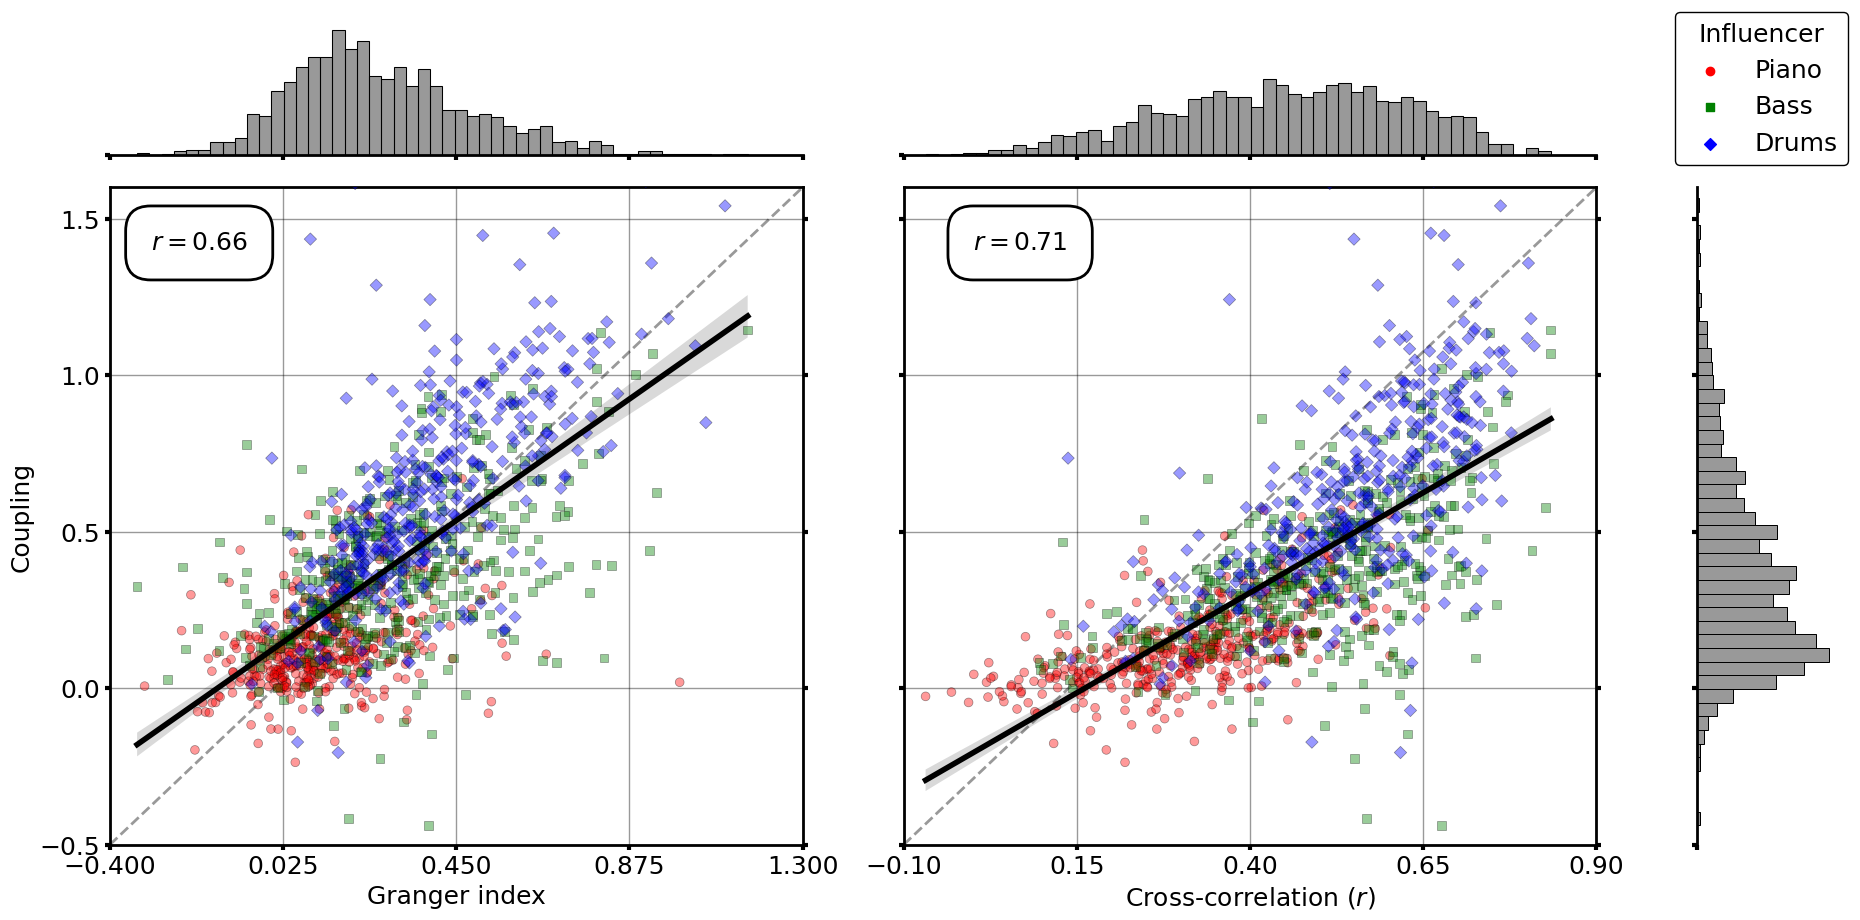

In [90]:
RegPlotCouplingGrangerCross(clean).create_plot()
plt.show()

### Compare higher-order models